In [1]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import os
import pickle
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorboardX import SummaryWriter



### 训练数据预处理 && 下载数据集

In [2]:
# 数据预处理
transform = transforms.Compose([
    #transforms.Resize(256),                
    #transforms.CenterCrop(224),        # 如果这里把原来32*32的图像放大到224*224，那么卷积网络的输出大小就是53*53
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CIFAR-10 dataset 导入
train_dataset = torchvision.datasets.CIFAR10(root='../dataset_CIFAR-10/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../dataset_CIFAR-10/',
                                            train=False, 
                                            transform=transforms.ToTensor())

Files already downloaded and verified


### 自定义CIFAR-10 数据集类

In [3]:
class CIFAR10Dataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        """
        root_dir (string): 数据集的目录。
        train (bool): 如果设置为True，则从训练集中加载数据，否则从测试集中加载。
        transform (callable, optional): 可选的转换函数，应用于图像。
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        # 根据训练或测试集加载不同的文件
        self.data = []
        self.labels = []
        if self.train:
            for i in range(1, 6):
                file = os.path.join(self.root_dir, 'data_batch_' + str(i))
                with open(file, 'rb') as fo:
                    dict = pickle.load(fo, encoding='bytes')
                    self.data.append(dict[b'data'])
                    self.labels += dict[b'labels']
            self.data = torch.cat([torch.tensor(d).view(-1, 3, 32, 32) for d in self.data])
        else:
            file = os.path.join(self.root_dir, 'test_batch')
            with open(file, 'rb') as fo:
                dict = pickle.load(fo, encoding='bytes')
                self.data = torch.tensor(dict[b'data']).view(-1, 3, 32, 32)
                self.labels = dict[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        # 将图像数据格式从[channels, height, width]转换为PIL图像格式
        image = Image.fromarray(image.numpy().transpose((1, 2, 0)))

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# 加载训练数据集
# 使用torch函数加载数据集
#trainset = datasets.CIFAR10(root='/mnt/ssd/dataset_CIFAR-10', train=True, download=True, transform=transform)
#  使用自定义的CIFAR10Dataset类加载数据集
trainset = CIFAR10Dataset(root_dir='../dataset_CIFAR-10/cifar-10-batches-py', train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)

# 加载测试数据集
#testset = datasets.CIFAR10(root='/mnt/ssd/dataset_CIFAR-10/cifar-10-batches-py', train=False, download=True, transform=transform)
# 使用自定义的CIFAR10Dataset类加载数据集
testset = CIFAR10Dataset(root_dir='../dataset_CIFAR-10/cifar-10-batches-py', train=False, transform=transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)

# CIFAR-10类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#### 加载数据集后(并且完成预处理了), 
#### 可视化一些训练样本(dataloader中的数据)

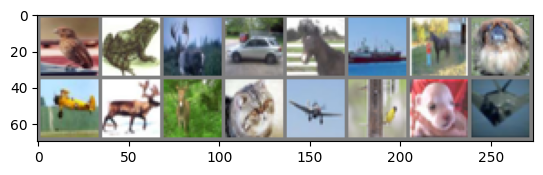

 bird, frog, deer,  car,horse, ship,horse,  dog,plane, deer, deer,  cat,plane, bird,  dog,plane


'\n# 显示一张图片与标签\nimshow(images[0])\nprint(classes[labels[0]])\n'

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # 反标准化normalize
    npimg = img.numpy()     # 将Tensor转换为ndarray
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 转换为[height, width, channels]
    plt.show()

# 获取一些随机训练图片
dataiter = iter(trainloader)    # 将trainloader转换为迭代器
images, labels = next(dataiter) # 获取一组图像和标签

# 显示批量图片
imshow(torchvision.utils.make_grid(images)) # 将一个batch_size的图像拼接成网格
print(','.join('%5s' % classes[labels[j]] for j in range(16)))

'''
# 显示一张图片与标签
imshow(images[0])
print(classes[labels[0]])
'''

## 简单CNN模型--LeNet

In [6]:
class LeNet(nn.Module):
    def __init__(self): #定义了网络的结构
        super(LeNet, self).__init__()
        # 第一个卷积层: 输入通道数为3（对于RGB图像），输出通道数为6，卷积核大小为5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 第二个卷积层: 输入通道数为6，输出通道数为16，卷积核大小为5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 最大池化层，使用2x2窗口, 步长为2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全连接层1: 输入特征数为16 * 6 * 6（16个通道，每个通道的大小是5x5），输出特征数为120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # 5*5是通过计算得到的图像大小
        # 全连接层2: 输入特征数为120，输出特征数为84
        self.fc2 = nn.Linear(120, 84)
        # 全连接层3（输出层）: 输入特征数为84，输出特征数为10（对应10个类别）
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):   #定义了数据通过网络的方式
        # 应用第一个卷积层 followed by ReLU激活函数和池化
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # 应用第二个卷积层 followed by ReLU激活函数和池化
        x = self.pool(F.relu(self.conv2(x)))
        # 展平所有除批次维度以外的维度
        x = x.view(-1, 16 * 5 * 5)
        # 应用第一个全连接层和ReLU激活函数
        x = self.fc1(x)
        x = F.relu(x)
        # 应用第二个全连接层和ReLU激活函数
        x = F.relu(self.fc2(x))
        # 应用输出层
        x = self.fc3(x)
        return x


In [7]:
# 定义模型
#model = ResNet(BasicBlock, [2, 2, 2, 2])
model = LeNet()
model.cuda()  # 将模型移动到GPU上（如果可用）

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 开始训练

In [8]:
#モデルの学習
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
epoch = 10
# 使用tensorboardX进行可视化
writer = SummaryWriter(comment='test_comment', filename_suffix="CIFAR10_Lenet")

for i in range(epoch):
    print('-'*5, 'Epoch [{}/{}] start'.format(i, epoch-1), '-'*5)
    epoch_loss = 0
    epoch_accuracy = 0
    model.train()
    for image, target in tqdm(trainloader):
        image, target = image.cuda(), target.cuda()
        output = model(image).squeeze()
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)
        
    # モデルの検証、評価モード切替
    model.eval()

    # 検証データのデータローダから読み込み尽くすまでループ
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss = 0

        for image, target in testloader:

            # 入力、正解を GPU へ移動
            image, target = image.cuda(), target.cuda()

            # モデルに入力を順伝播させ予測を出力
            output = model(image).squeeze()

            # 損失関数で予測と正解の誤差や精度を導出
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            epoch_val_accuracy += acc / len(testloader)
            epoch_val_loss += loss / len(testloader)

    print('epoch',epoch)
    print('acc',epoch_accuracy)
    print('loss',epoch_loss)
    print('val_acc',epoch_val_accuracy)
    print('val_loss',epoch_val_loss)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_accuracy)
    val_loss_list.append(epoch_val_loss)
    val_acc_list.append(epoch_val_accuracy)
    writer.add_scalar('train_loss', epoch_loss, i)
    writer.add_scalar('train_acc', epoch_accuracy, i)
    writer.add_scalar('val_loss', epoch_val_loss, i)
    writer.add_scalar('val_acc', epoch_val_accuracy, i)

writer.close()

----- Epoch [0/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 582.00it/s]


epoch 10
acc tensor(0.2439, device='cuda:0')
loss tensor(2.0490, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.3702, device='cuda:0')
val_loss tensor(1.7044, device='cuda:0')
----- Epoch [1/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 596.80it/s]


epoch 10
acc tensor(0.4156, device='cuda:0')
loss tensor(1.5984, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.4520, device='cuda:0')
val_loss tensor(1.5025, device='cuda:0')
----- Epoch [2/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 614.25it/s]


epoch 10
acc tensor(0.4821, device='cuda:0')
loss tensor(1.4340, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.5012, device='cuda:0')
val_loss tensor(1.3788, device='cuda:0')
----- Epoch [3/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 619.61it/s]


epoch 10
acc tensor(0.5310, device='cuda:0')
loss tensor(1.3083, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.5325, device='cuda:0')
val_loss tensor(1.2924, device='cuda:0')
----- Epoch [4/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 598.86it/s]


epoch 10
acc tensor(0.5677, device='cuda:0')
loss tensor(1.2108, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.5668, device='cuda:0')
val_loss tensor(1.2071, device='cuda:0')
----- Epoch [5/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 601.15it/s]


epoch 10
acc tensor(0.5953, device='cuda:0')
loss tensor(1.1407, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.5851, device='cuda:0')
val_loss tensor(1.1627, device='cuda:0')
----- Epoch [6/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 604.84it/s]


epoch 10
acc tensor(0.6157, device='cuda:0')
loss tensor(1.0821, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.5807, device='cuda:0')
val_loss tensor(1.1909, device='cuda:0')
----- Epoch [7/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 605.65it/s]


epoch 10
acc tensor(0.6350, device='cuda:0')
loss tensor(1.0319, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.6034, device='cuda:0')
val_loss tensor(1.1273, device='cuda:0')
----- Epoch [8/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 611.95it/s]


epoch 10
acc tensor(0.6534, device='cuda:0')
loss tensor(0.9841, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.6039, device='cuda:0')
val_loss tensor(1.1284, device='cuda:0')
----- Epoch [9/9] start -----


100%|██████████| 3125/3125 [00:05<00:00, 577.58it/s]


epoch 10
acc tensor(0.6647, device='cuda:0')
loss tensor(0.9485, device='cuda:0', grad_fn=<AddBackward0>)
val_acc tensor(0.6180, device='cuda:0')
val_loss tensor(1.1033, device='cuda:0')
